# Test Suit 1 - Vector embedding model testing
### Import all dependancies.
Do pip installs as required

In [1]:
import pandas as pd
import numpy as np
import pickle
import faiss
from sentence_transformers import SentenceTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score
import random
import os
import time
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


### Mapping FAISS embeddings location for further use

In [2]:
model_map = {
    "1": "sentence-transformers/multi-qa-MiniLM-L6-cos-v1",
    "2": "sentence-transformers/all-MiniLM-L6-v2",
    "3": "sentence-transformers/all-distilroberta-v1",
    "4": "sentence-transformers/distilbert-base-nli-stsb-mean-tokens",
    "5": "sentence-transformers/all-MiniLM-L12-v2",
}

index_map = {
    "1": "./../faiss_embeddings1/movie_index.faiss",
    "2": "./../faiss_embeddings2/movie_index.faiss",
    "3": "./../faiss_embeddings3/movie_index.faiss",
    "4": "./../faiss_embeddings4/movie_index.faiss",
    "5": "./../faiss_embeddings5/movie_index.faiss",
}

id_list_map = {
    "1": "./../faiss_embeddings1/movie_ids.pkl",
    "2": "./../faiss_embeddings2/movie_ids.pkl",
    "3": "./../faiss_embeddings3/movie_ids.pkl",
    "4": "./../faiss_embeddings4/movie_ids.pkl",
    "5": "./../faiss_embeddings5/movie_ids.pkl",
}

CSV_PATH = "./../cleaned_database/cleaned_final_dataset3.csv"


In [3]:
def load_dataset(path, sample_size):
    df = pd.read_csv(path)
    df = df.dropna(subset=["title", "id"]).reset_index(drop=True)
    sampled_df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    return sampled_df


In [4]:
def load_model_and_index(model_choice):
    model_name = model_map[model_choice]
    model = SentenceTransformer(model_name)

    index_path = index_map[model_choice]
    index = faiss.read_index(index_path)

    with open(id_list_map[model_choice], "rb") as f:
        id_list = pickle.load(f)

    return model, index, id_list


In [5]:
import chromadb


chroma_client = chromadb.PersistentClient(path="./../chromadb_client")
collection = chroma_client.get_collection(name="best_movies_database")

In [6]:
def run_chromadb_model(collection, df, top_k=10, query_column="title", validate_column="id"):
    from time import time

    print("\nRunning model: ChromaDB")
    results = []
    start_time = time()

    for _, row in tqdm(df.iterrows(), total=len(df)):
        query = str(row[query_column])
        actual_id = str(row[validate_column])

        response = collection.query(
            query_texts=[query],
            n_results=top_k
        )

        retrieved_ids = [str(rid) for rid in response["ids"][0]]

        if actual_id in retrieved_ids:
            rank = retrieved_ids.index(actual_id)
            hit = 1
        else:
            rank = -1
            hit = 0

        results.append({
            "query": query,
            "actual_id": actual_id,
            "retrieved_ids": retrieved_ids,
            "hit": hit,
            "rank": rank,
            "distance": None,  # Not available in ChromaDB
            "distance_scores": None,  # Also not available
            "model": "chromadb",
        })

    total_time = time() - start_time
    return results, total_time


In [7]:
def run_model(model_choice, df, top_k=10, query_column="title", validate_column="id"):
    print(f"\nRunning model {model_choice}: {model_map[model_choice]}")
    model, index, id_list = load_model_and_index(model_choice)
    results = []
    start_time = time.time()

    for i, row in tqdm(df.iterrows(), total=len(df)):
        query = str(row[query_column])
        actual_id = str(row[validate_column])
        embedding = model.encode([query], normalize_embeddings=True).astype("float32")
        D, I = index.search(embedding, top_k)
        retrieved_ids = [str(id_list[idx]) for idx in I[0]]

        if actual_id in retrieved_ids:
            rank = retrieved_ids.index(actual_id)
            hit = 1
            distance = D[0][rank]
        else:
            rank = -1
            hit = 0
            distance = None

        results.append({
            "query": query,
            "actual_id": actual_id,
            "retrieved_ids": retrieved_ids,
            "hit": hit,
            "rank": rank,
            "distance": distance,
            "distance_scores": D[0].tolist(),
            "model": model_choice,
        })


    total_time = time.time() - start_time
    return results, total_time

In [8]:
def analyze_results(results):
    hits = [r for r in results if r["hit"] == 1]
    ranks = [r["rank"] for r in hits]
    distances = [r["distance"] for r in hits if r["distance"] is not None]
    reciprocal_ranks = [1 / (r + 1) for r in ranks]

    return {
        "accuracy": len(hits) / len(results),
        "mean_rank": np.mean(ranks) if ranks else None,
        "mean_distance": np.mean(distances) if distances else None,
        "mrr": np.mean(reciprocal_ranks) if reciprocal_ranks else None
    }


In [9]:
def compute_accuracy(results):
    hits = sum([r["hit"] for r in results])
    return hits / len(results)

In [10]:
def run_all_models(model_choices, sample_size=1000, top_k=10,
                   query_column="title", validate_column="id",
                   include_chromadb=False, collection=None):
    
    df = load_dataset(CSV_PATH, sample_size)
    all_outputs = []
    summary = []

    for model_choice in model_choices:
        results, time_taken = run_model(
            model_choice, df, top_k, query_column, validate_column
        )
        stats = analyze_results(results)

        summary.append({
            "model": model_map[model_choice],
            "accuracy": stats["accuracy"],
            "mean_rank": stats["mean_rank"],
            "mean_distance": stats["mean_distance"],
            "mrr": stats["mrr"],
            "total_time_sec": time_taken,
            "avg_time_per_query_ms": time_taken / len(df) * 1000
        })

        all_outputs.append((model_choice, results))

    if include_chromadb:
        assert collection is not None, "You must pass a ChromaDB collection to include it."
        chroma_results, chroma_time = run_chromadb_model(
            collection, df, top_k, query_column, validate_column
        )
        chroma_stats = analyze_results(chroma_results)

        summary.append({
            "model": "ChromaDB",
            "accuracy": chroma_stats["accuracy"],
            "mean_rank": chroma_stats["mean_rank"],
            "mean_distance": chroma_stats["mean_distance"],
            "mrr": chroma_stats["mrr"],
            "total_time_sec": chroma_time,
            "avg_time_per_query_ms": chroma_time / len(df) * 1000
        })

        all_outputs.append(("chromadb", chroma_results))

    return pd.DataFrame(summary), all_outputs


In [18]:
summary_df, all_results = run_all_models(
    model_choices=["1", "2", "3", "4", "5"],
    sample_size=20000,
    top_k=10,
    include_chromadb=True,
    collection=collection
)


Running model 1: sentence-transformers/multi-qa-MiniLM-L6-cos-v1


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 2: sentence-transformers/all-MiniLM-L6-v2


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 3: sentence-transformers/all-distilroberta-v1


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 4: sentence-transformers/distilbert-base-nli-stsb-mean-tokens


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 5: sentence-transformers/all-MiniLM-L12-v2


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model: ChromaDB


  0%|          | 0/20000 [00:00<?, ?it/s]

In [15]:
import matplotlib.pyplot as plt

In [19]:


def plot_faiss_summary_metrics(summary_df, title="FAISS Evaluation Metrics Overview"):
    fig, ax = plt.subplots(2, 3, figsize=(20, 12))

    metrics = [
        ("accuracy", "Top-K Accuracy", 'steelblue', 0, 1),
        ("mean_rank", "Mean Rank of Hit", 'indianred', None, None),
        ("mrr", "Mean Reciprocal Rank (MRR)", 'slateblue', 0, 1),
        ("mean_distance", "Mean Distance of Hit", 'darkgreen', None, None),
        ("total_time_sec", "Total Time Taken (s)", 'darkorange', None, None),
        ("avg_time_per_query_ms", "Avg Time per Query (ms)", 'mediumseagreen', None, None)
    ]

    for i, (metric, title_str, color, ymin, ymax) in enumerate(metrics):
        row, col = divmod(i, 3)
        ax[row, col].bar(summary_df["model"], summary_df[metric], color=color)
        ax[row, col].set_title(title_str)
        if ymin is not None and ymax is not None:
            ax[row, col].set_ylim(ymin, ymax)
        ax[row, col].grid(True)

        # Add value labels
        for idx, value in enumerate(summary_df[metric]):
            ax[row, col].text(idx, value + (0.01 if ymax == 1 else value * 0.01), f"{value:.2f}",
                              ha='center', va='bottom', fontsize=10)

    # Common axis styling
    for row_axes in ax:
        for axis in row_axes:
            axis.set_xlabel("Model")
            axis.set_xticks(range(len(summary_df)))
            axis.set_xticklabels(summary_df["model"], rotation=45)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


posx and posy should be finite values
posx and posy should be finite values


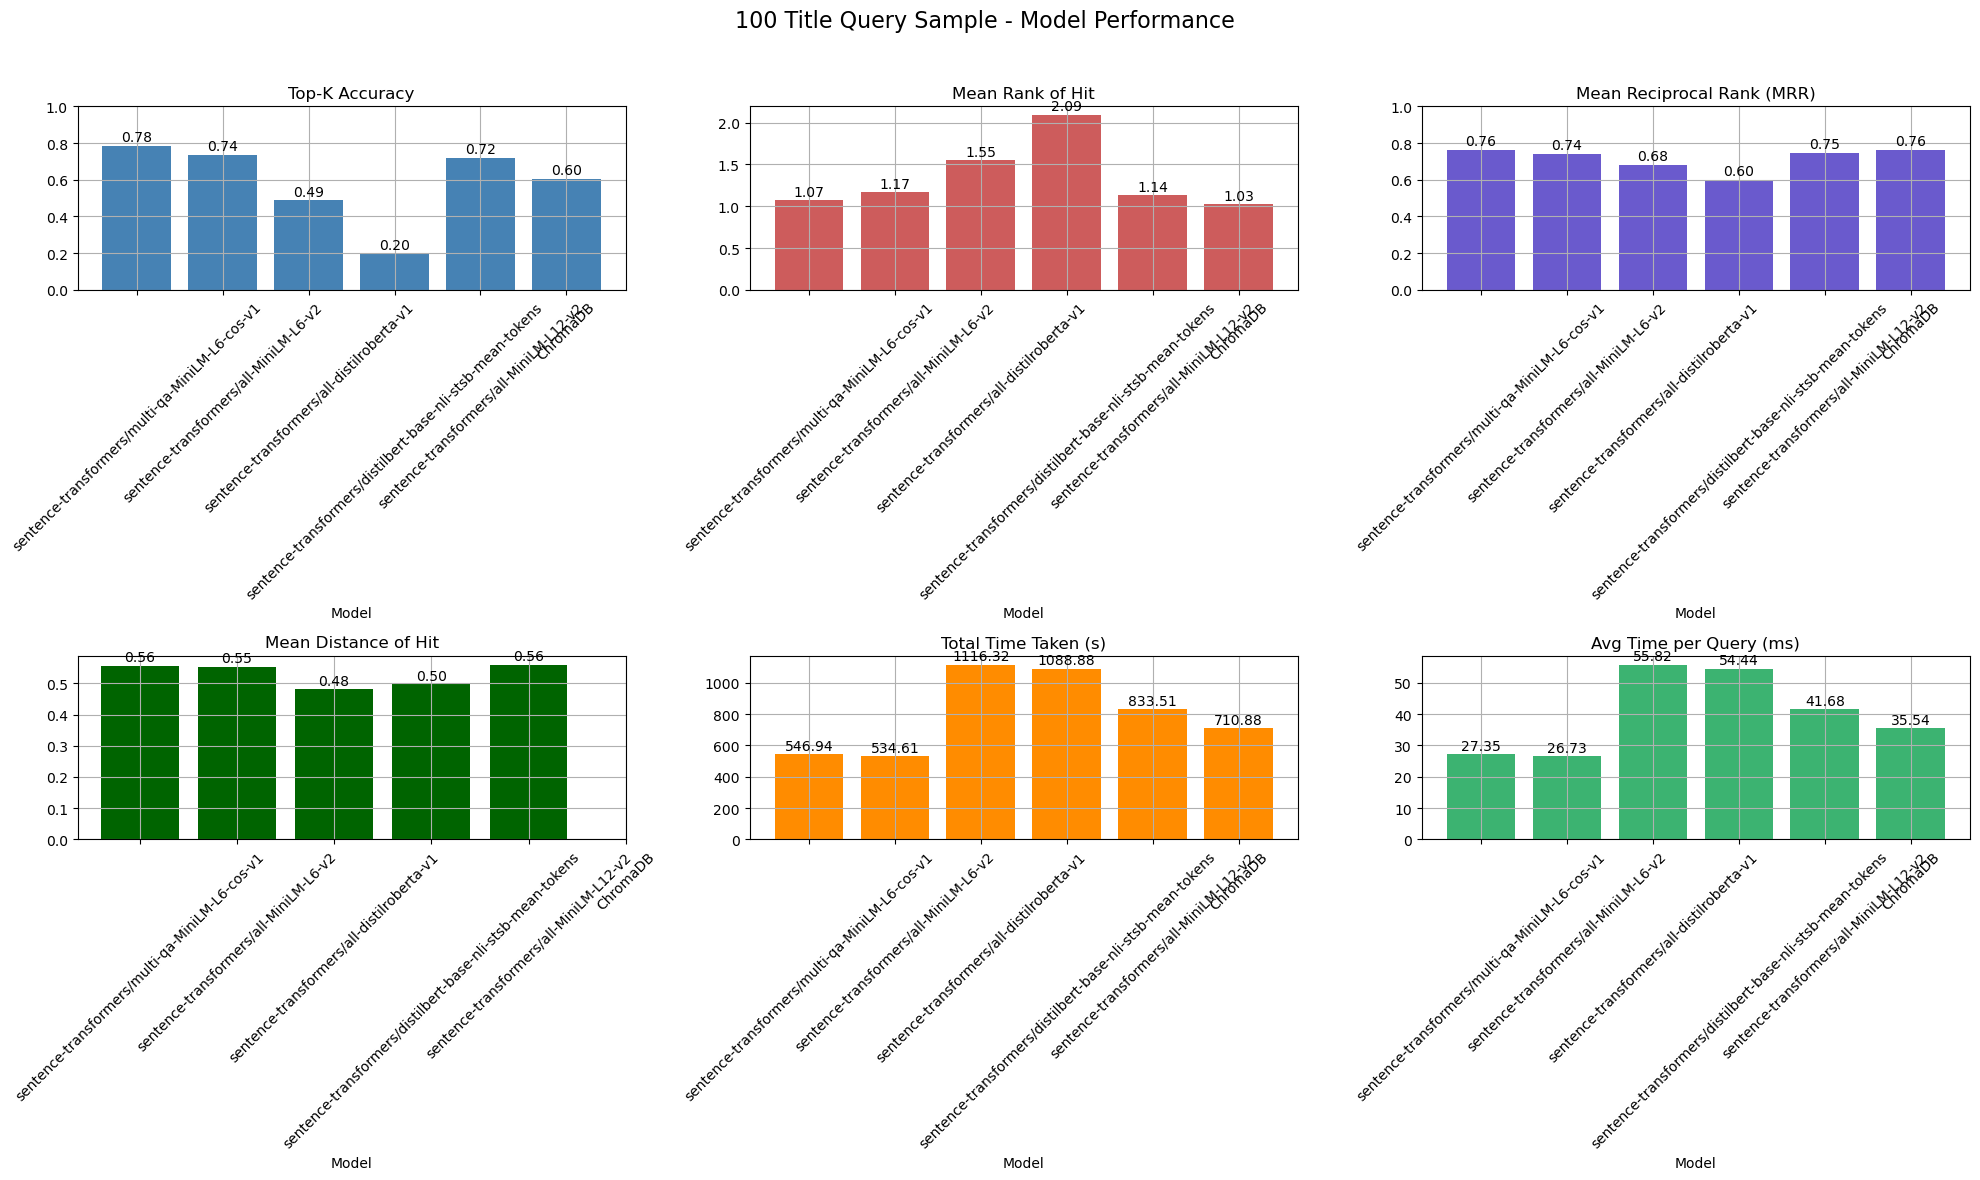

In [20]:
plot_faiss_summary_metrics(summary_df, title="100 Title Query Sample - Model Performance")


In [22]:
summary_df2, all_results2 = run_all_models(
    model_choices=["1", "2", "3", "4", "5"],
    sample_size=20000,
    top_k=10,
    query_column="description",
    include_chromadb=True,
    collection=collection
)


Running model 1: sentence-transformers/multi-qa-MiniLM-L6-cos-v1


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 2: sentence-transformers/all-MiniLM-L6-v2


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 3: sentence-transformers/all-distilroberta-v1


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 4: sentence-transformers/distilbert-base-nli-stsb-mean-tokens


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model 5: sentence-transformers/all-MiniLM-L12-v2


  0%|          | 0/20000 [00:00<?, ?it/s]


Running model: ChromaDB


  0%|          | 0/20000 [00:00<?, ?it/s]

posx and posy should be finite values
posx and posy should be finite values


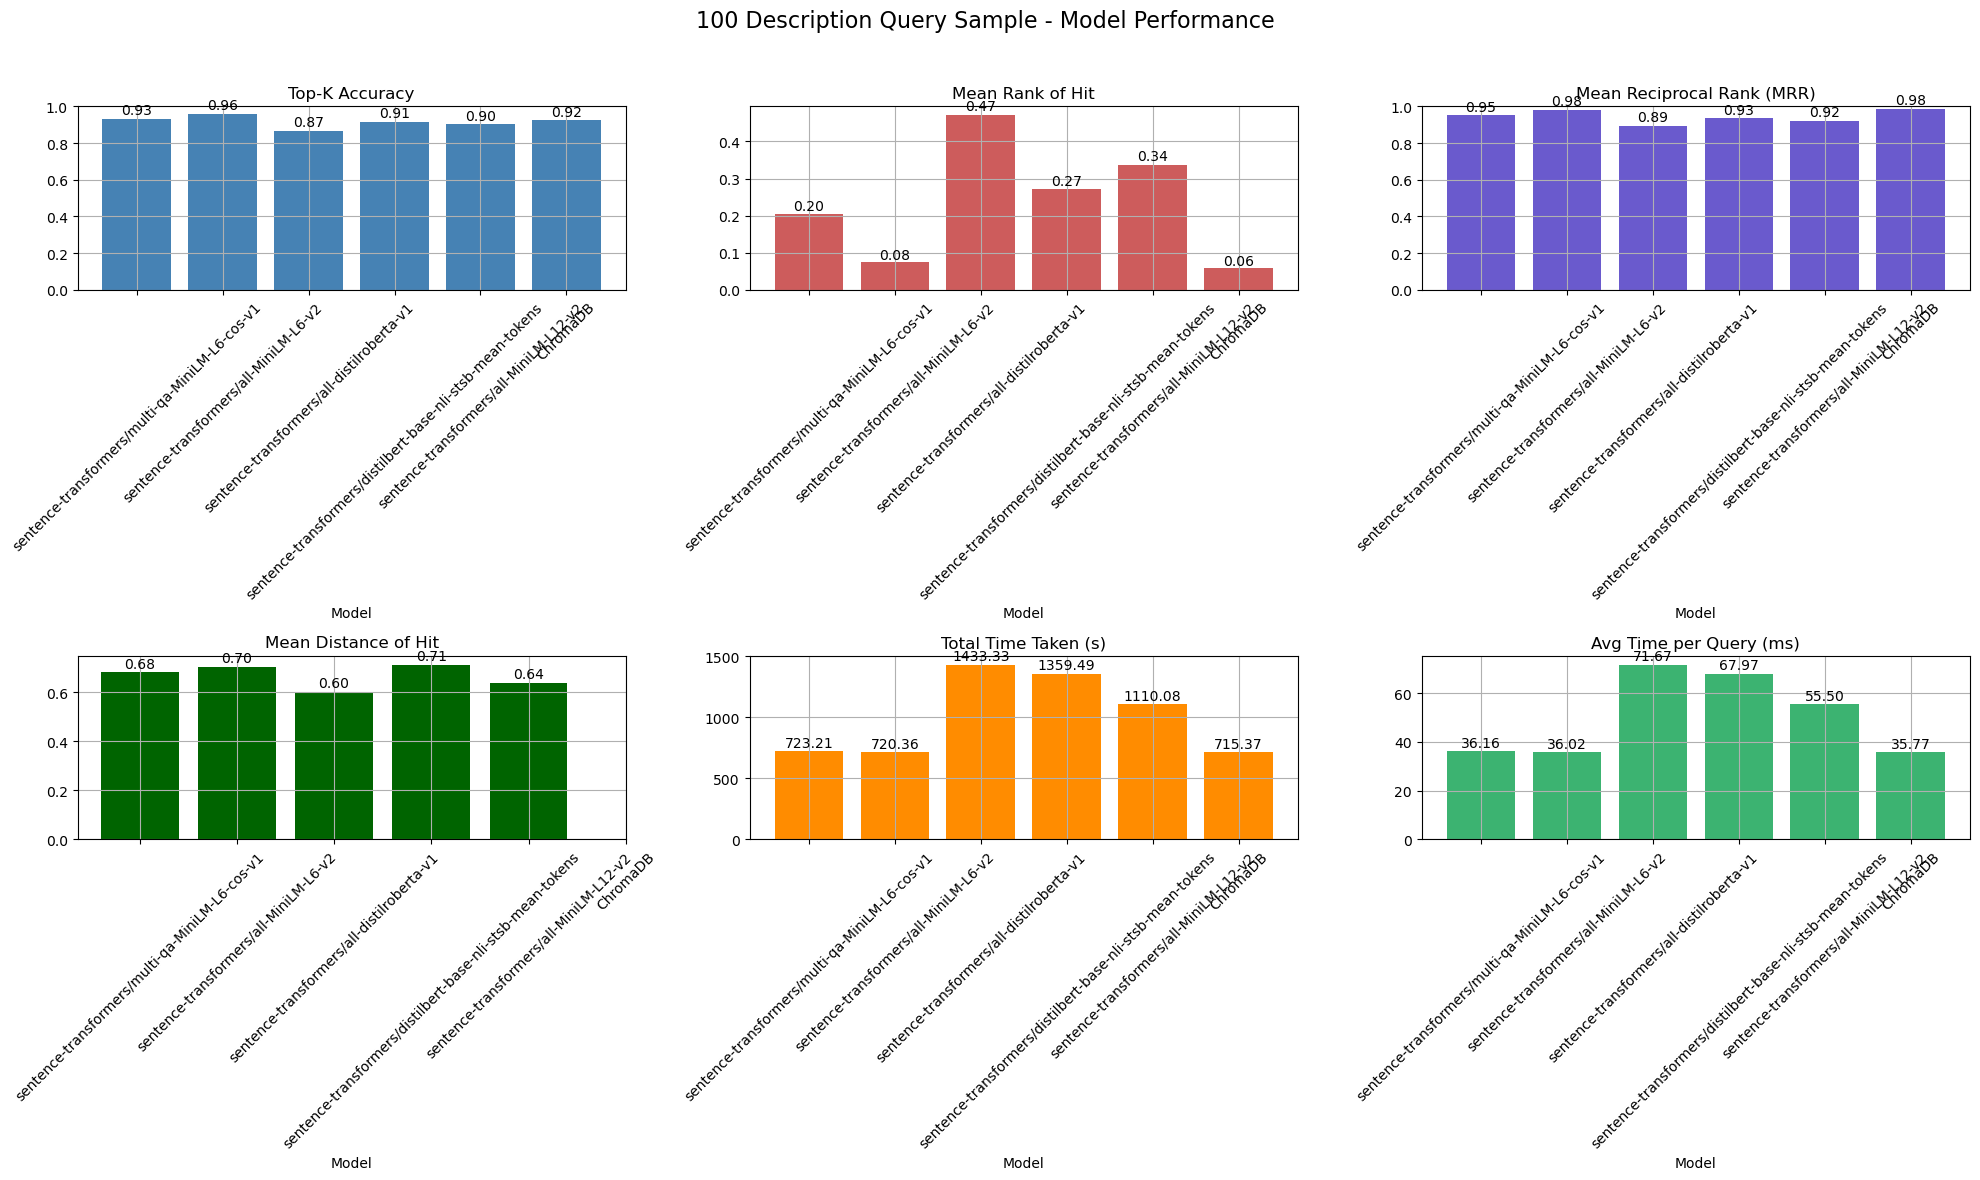

In [23]:
plot_faiss_summary_metrics(summary_df2, title="100 Description Query Sample - Model Performance")